In [1]:
'''
Model:
    3 Layers GAT + 2 Layer FC
    hidden channel = 32
    training 1500 epoch
    symmetric net
    seperate capacitors and resistors

'''

'\nModel:\n    3 Layers GAT + 2 Layer FC\n    hidden channel = 32\n    training 1500 epoch\n    symmetric net\n    seperate capacitors and resistors\n\n'

In [2]:
import numpy as np
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, BatchNorm, Linear, GATConv

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.__version__)
!python --version
!nvcc --version
!cat /usr/include/cudnn.h | grep CUDNN_MAJOR -A 2

cuda
1.11.0+cu102
Python 3.8.6
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
#define CUDNN_MAJOR 7
#define CUDNN_MINOR 6
#define CUDNN_PATCHLEVEL 1
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


cuda:1
1.11.0+cu102
Python 3.8.6
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
Device Node Features' Shape: (4840, 5)
Device Node Features' Mean: [1.4687221e+08 1.3245618e+09 8.9800166e+03 6.6443965e+03 9.2293388e-01]
Device Node Features' Std: [4.6006429e+08 2.3239562e+09 9.8264346e+03 1.1724921e+04 1.2513181e+00]
Net Node Features' Shape: (4573, 6)
Net Node Features' Mean: [6.6652089e-01 1.0146512e-01 3.9930025e-01 3.5097311e+00 3.9738026e+01
 3.5140730e+04]
Net Node Features' Std: [9.4276470e-01 3.0193734e-01 4.8974955e-01 3.6381481e+00 3.0870703e+01
 4.6655129e+04]
DataSet size:
266
Total Device: 4840
NumMos: 2891
NumCap: 530
NumRes: 320
NumBlock: 1099
Num wire: 4109
L min:168.0
L max:532336.0
Interval: 2337.52


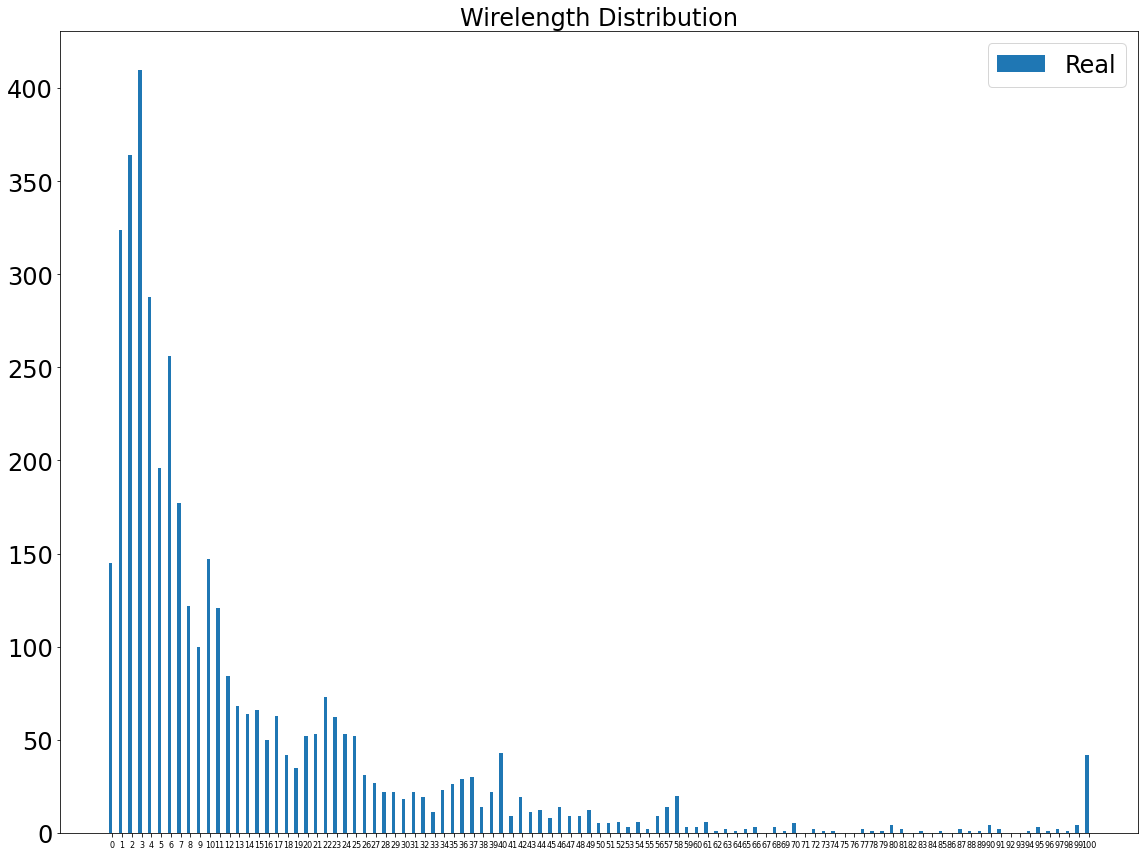

[1.20960e+06 1.20960e+06 1.20960e+06 ... 3.04886e+09 3.04886e+09
 3.04886e+09]
Num device: 4840
L min:1209600.0
L max:3048860000.0
Interval: 20889803.52


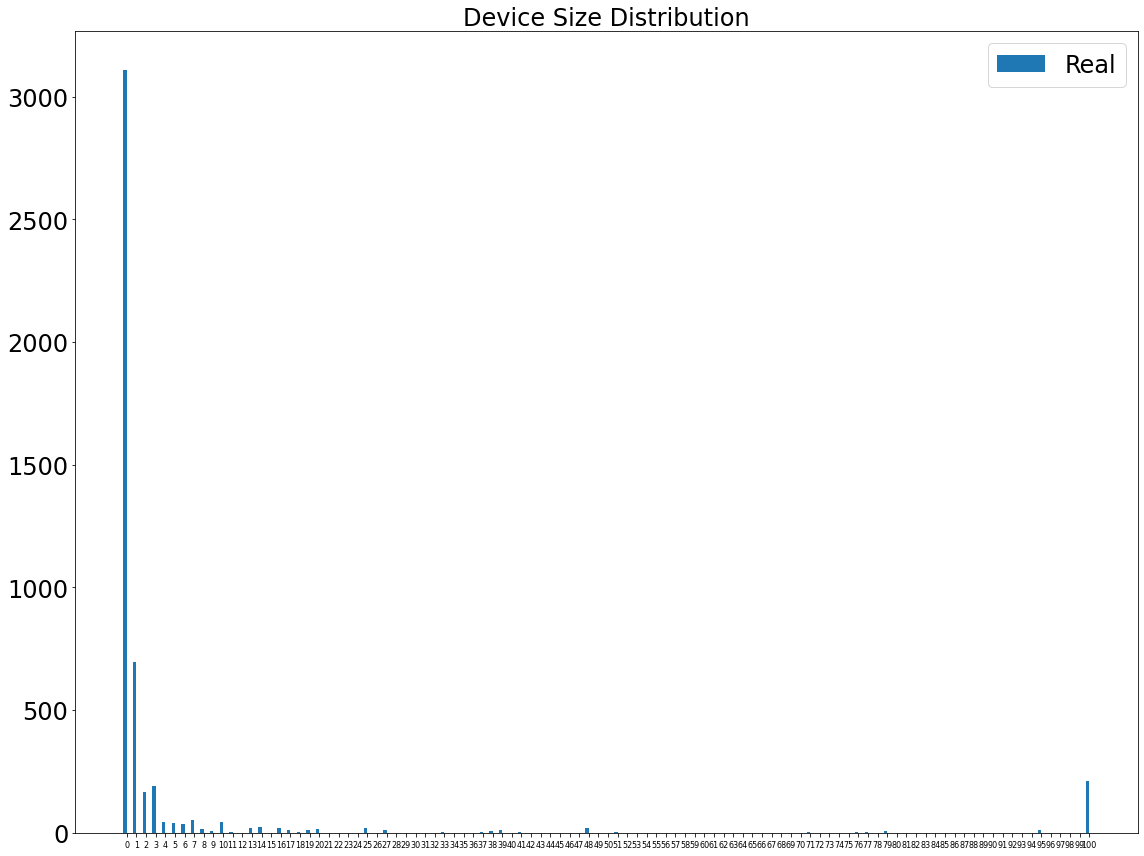

ALIGN(266)


In [4]:
%run ../Dataset_Generation.ipynb
#import import_ipynb
#import Dataset_Generation.ipynb
dataset = ALIGN(root='data')

In [5]:
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset


train_dataset = dataset[0:240]
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = dataset[240:]
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(train_dataset)

ALIGN(240)


In [6]:
for i, data in enumerate(train_loader):
    print(i)
    print(data)
    print(data.edge_index_dict[('device', 'gate2net', 'net')])
    print(data.edge_index_dict[('net', 'net2gate', 'device')])
    break

0
HeteroDataBatch(
  device={
    x=[69, 5],
    batch=[69],
    ptr=[5]
  },
  net={
    y=[61],
    train_mask=[61],
    smallnet_mask=[61],
    largenet_mask=[61],
    x=[61, 5],
    batch=[61],
    ptr=[5]
  },
  (device, gate2net, net)={ edge_index=[2, 65] },
  (net, net2gate, device)={ edge_index=[2, 65] },
  (device, source2net, net)={ edge_index=[2, 142] },
  (net, net2source, device)={ edge_index=[2, 142] },
  (device, cap2net, net)={ edge_index=[2, 8] },
  (net, net2cap, device)={ edge_index=[2, 8] },
  (device, res2net, net)={ edge_index=[2, 0] },
  (net, net2res, device)={ edge_index=[2, 0] },
  (net, net2net, net)={ edge_index=[2, 40] }
)
tensor([[ 2,  0,  7,  0,  6,  8,  5, 19, 20, 17,  9, 10, 15, 15, 14, 13, 23, 29,
         27, 25, 32, 34, 26, 24, 21, 33, 30, 35, 22, 28, 36, 31, 43, 44, 65, 50,
         37, 59, 48, 39, 54, 46, 66, 47, 45, 42, 55, 62, 51, 41, 53, 60, 64, 67,
         40, 57, 61, 68, 42, 49, 38, 58, 52, 63, 56],
        [ 3,  4,  8,  9, 13, 13, 15, 17, 17

In [7]:
class Hetero_Model (torch.nn.Module):
    
    def __init__(self, heads=2, hidden_channel=32):
        super().__init__()
        
        self.fc1_device = Linear(in_channels=5, out_channels=hidden_channel)
        self.fc1_net    = Linear(in_channels=5, out_channels=hidden_channel)
        
        self.hetero_conv1 = HeteroConv({
                    ('device', 'gate2net', 'net'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'source2net', 'net'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'cap2net', 'net'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'res2net', 'net'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2gate', 'device'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2source', 'device'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2cap', 'device'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2res', 'device'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2net', 'net'): GATConv(in_channels=hidden_channel, out_channels=hidden_channel, heads=2, dropout=0.5)
                    }, aggr='sum')
        self.bnm1_device         = BatchNorm(hidden_channel*2)
        self.bnm1_net            = BatchNorm(hidden_channel*2)
        
        self.hetero_conv2 = HeteroConv({
                    ('device', 'gate2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'source2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'cap2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'res2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2gate', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2source', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2cap', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2res', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5)
                    }, aggr='sum')
        self.bnm2_device         = BatchNorm(hidden_channel*2)
        self.bnm2_net            = BatchNorm(hidden_channel*2)
            
        self.hetero_conv3 = HeteroConv({
                    ('device', 'gate2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'source2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'cap2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('device', 'res2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2gate', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2source', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2cap', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2res', 'device'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5),
                    ('net', 'net2net', 'net'): GATConv(in_channels=hidden_channel*2, out_channels=hidden_channel, heads=2, dropout=0.5)
                    }, aggr='sum')
        self.bnm3_device         = BatchNorm(hidden_channel*2)
        self.bnm3_net            = BatchNorm(hidden_channel*2)
        
        self.fc1  = Linear(hidden_channel*2*3, hidden_channel)
        self.bnm4 = BatchNorm(hidden_channel)
        self.fc2  = Linear(hidden_channel, 1)
        
    
    def forward(self, x_dict, edge_index_dict):
        
        x_dict['device'] = self.fc1_device(x_dict['device'])
        x_dict['net']    = self.fc1_net(x_dict['net'])
        

        x_dict           = self.hetero_conv1(x_dict, edge_index_dict)
        x_dict['device'] = self.bnm1_device(x_dict['device'])
        x_dict['net']    = self.bnm1_net(x_dict['net'])
        x_dict['device'] = F.elu(x_dict['device'])
        x_dict['net']    = F.elu(x_dict['net'])
        h1               = F.elu(x_dict['net'])
        
      
        x_dict           = self.hetero_conv2(x_dict, edge_index_dict)
        x_dict['device'] = self.bnm2_device(x_dict['device'])
        x_dict['net']    = self.bnm2_net(x_dict['net'])
        x_dict['device'] = F.elu(x_dict['device'])
        x_dict['net']    = F.elu(x_dict['net'])
        h2               = F.elu(x_dict['net'])
        
                
        x_dict           = self.hetero_conv3(x_dict, edge_index_dict)
        x_dict['device'] = self.bnm3_device(x_dict['device'])
        x_dict['net']    = self.bnm3_net(x_dict['net'])
        x_dict['device'] = F.elu(x_dict['device'])
        x_dict['net']    = F.elu(x_dict['net'])
        h3               = F.elu(x_dict['net'])
        
        x = torch.cat((h1, h2, h3), dim=1) 
        
        x = self.fc1(x)
        x = F.elu(x)
        x = F.dropout(x, 0.5, self.training)
        x = self.fc2(x)
        x = F.elu(x)
        
        return x

In [8]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)
model = Hetero_Model().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.7)
criterion = nn.MSELoss()


cuda:1


In [9]:
#model.to(device)
#model.load_state_dict(torch.load('./HAT_Symmetric_Cap_Res')['model_state_dict'])
#optimizer.load_state_dict(torch.load('./HAT_Symmetric_Cap_Res')['optimizer_state_dict'])

#print(device)


In [10]:
model.train()
Model_Path = './HAT_Symmetric_Cap_Res.pth'

i = 0
for epoch in range(1000):
    model.train()
        
    for data in train_loader:
        
        optimizer.zero_grad()  
        data.to(device)
        out = model(data.x_dict, data.edge_index_dict).squeeze()
        
        loss = criterion(out[data.train_mask_dict['net']], data.y_dict['net'][data.train_mask_dict['net']])
        loss.backward()
        optimizer.step()
        
        #data.to('cpu')
        #torch.cuda.empty_cache()
    
    scheduler.step()
    if epoch%10 == 0:
        print(f'[{epoch + 1}] loss: {loss:.5f}')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, Model_Path)
    if epoch%100 == 0:
        print(f'[{epoch + 1}] lr: {optimizer.param_groups[0]["lr"]}')
    
    

[1] loss: 915305024.00000
[1] lr: 0.005
[11] loss: 607659136.00000
[21] loss: 868862272.00000
[31] loss: 440132320.00000
[41] loss: 350862400.00000
[51] loss: 625744704.00000
[61] loss: 355495552.00000
[71] loss: 201725168.00000
[81] loss: 264729424.00000
[91] loss: 530410368.00000
[101] loss: 1647270144.00000
[101] lr: 0.0034999999999999996
[111] loss: 294461600.00000
[121] loss: 632258432.00000
[131] loss: 90037736.00000
[141] loss: 316785312.00000
[151] loss: 320752960.00000
[161] loss: 574688512.00000
[171] loss: 293733920.00000
[181] loss: 629082944.00000
[191] loss: 755149376.00000
[201] loss: 1268748672.00000
[201] lr: 0.0024499999999999995
[211] loss: 2003071872.00000
[221] loss: 2683429376.00000
[231] loss: 1696472192.00000
[241] loss: 113199888.00000
[251] loss: 3500858368.00000
[261] loss: 272718496.00000
[271] loss: 660299776.00000
[281] loss: 205563344.00000
[291] loss: 653056960.00000
[301] loss: 742133696.00000
[301] lr: 0.0017149999999999995
[311] loss: 870494464.00000


In [11]:
Model_Path = './HAT_Symmetric_Cap_Res.pth'
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, Model_Path)

In [ ]:
model.load_state_dict(torch.load('./HAT_Symmetric_Cap_Res.pth')['model_state_dict'])
optimizer.load_state_dict(torch.load('./HAT_Symmetric_Cap_Res.pth')['optimizer_state_dict'])

In [20]:
model.eval()
test_acc_list = []
out_list = []
ans_list = []
model.to('cpu')

for data in test_loader:
    
    #print(data.x_dict)
    out = model(data.x_dict, data.edge_index_dict).squeeze()
    loss = criterion(out[data.train_mask_dict['net']], data.y_dict['net'][data.train_mask_dict['net']])
    print(loss)
    
    #out = torch.exp(out[data.train_mask_dict['net']]).detach().numpy()
    out = out[data.train_mask_dict['net']].detach().numpy()
    #print(out)
    
    #ans = torch.exp(data.y_dict['net'][data.train_mask_dict['net']]).detach().numpy()
    ans = data.y_dict['net'][data.train_mask_dict['net']].detach().numpy()
    #print(ans)
    
    mape = np.multiply(np.mean(np.divide(np.absolute(np.subtract(ans, out)), ans)), 100)
    mse = np.mean(np.absolute(np.subtract(ans, out)))
    print("MAPE: " + str(mape) + "%")
    print("MSE: " + str(mse))
    print()
    

    for i in range(out.shape[0]):
        if(ans[i] <= 300000):
            out_list.append(out[i])
            ans_list.append(ans[i])
    
        
#print(out_list)
#print(ans_list)

print(len(out_list))
print(len(ans_list))

out_list = np.array(out_list)
ans_list = np.array(ans_list) 
overall_mape = np.multiply(np.mean(np.divide(np.absolute(np.subtract(ans_list, out_list)), ans_list)), 100)
overall_mse = np.mean(np.absolute(np.subtract(ans_list, out_list)))
print("Overall MAPE: " + str(overall_mape) + "%")
print("Overall MSE: " + str(overall_mse))

tensor(37839232., grad_fn=<MseLossBackward0>)
MAPE: 51.11503601074219%
MSE: 4762.3286

tensor(12965841., grad_fn=<MseLossBackward0>)
MAPE: 54.35335636138916%
MSE: 2779.723

tensor(20670314., grad_fn=<MseLossBackward0>)
MAPE: 66.35366678237915%
MSE: 4140.013

tensor(8.2447e+08, grad_fn=<MseLossBackward0>)
MAPE: 42.673224210739136%
MSE: 21255.857

tensor(1.6354e+09, grad_fn=<MseLossBackward0>)
MAPE: 176.62168741226196%
MSE: 31583.764

tensor(28764160., grad_fn=<MseLossBackward0>)
MAPE: 71.20136022567749%
MSE: 4149.6084

tensor(2.5288e+09, grad_fn=<MseLossBackward0>)
MAPE: 65.99244475364685%
MSE: 45959.11

tensor(7.3424e+09, grad_fn=<MseLossBackward0>)
MAPE: 44.89966034889221%
MSE: 63439.438

tensor(11191910., grad_fn=<MseLossBackward0>)
MAPE: 37.33330965042114%
MSE: 2984.1953

tensor(20104150., grad_fn=<MseLossBackward0>)
MAPE: 65.57475924491882%
MSE: 3900.1877

tensor(8.8569e+09, grad_fn=<MseLossBackward0>)
MAPE: 48.518410325050354%
MSE: 71528.984

tensor(2.3175e+08, grad_fn=<MseLossBac

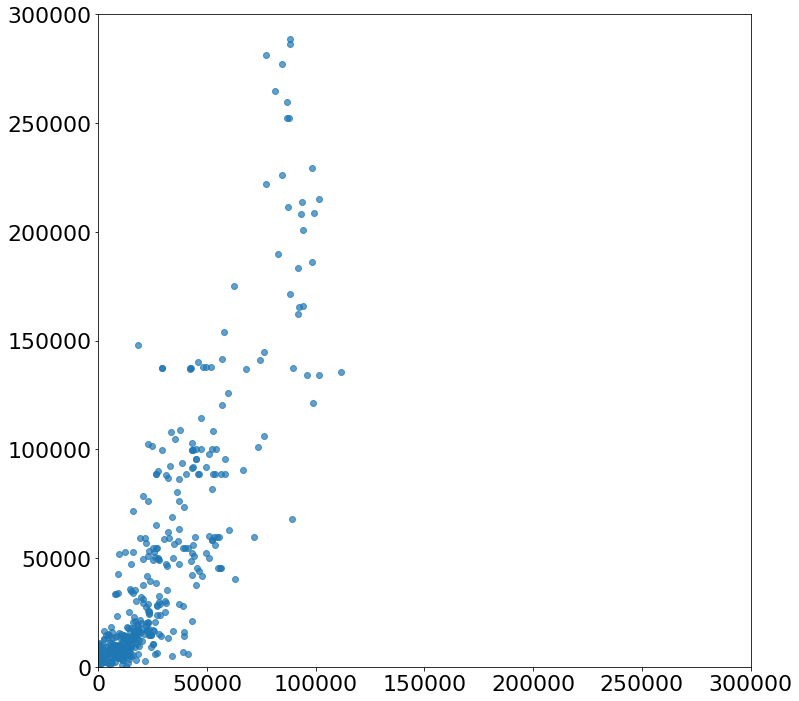

In [21]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize = (12, 12))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
ax.scatter(out_list, ans_list, alpha=0.7)
plt.axis('square')
plt.xlim(0, 300000)
plt.ylim(0, 300000)
plt.show()

In [14]:
N = 20

num_wire = len(out_list)
ans_sorted = np.sort(ans_list)
#out_sorted = np.sort(out_list) 
print("Num wire: " + str(num_wire))
    
L_min = ans_sorted[0]
L_max = ans_sorted[(num_wire-1) - int(0.05*num_wire)]
print("L min:" + str(L_min))
print("L max:" + str(L_max))
    
ans_label = np.zeros(num_wire)
out_label = np.zeros(num_wire)
interval = (L_max-L_min) / N
print("Interval: " + str(interval))
    
       
for i in range(N+1):
    interval_min = L_min + (i*interval)
    interval_max = L_min + ((i+1)*interval)
        
    if (i == N):
        ans_label = np.where((ans_list >= interval_min), i, ans_label)
        out_label = np.where((out_list >= interval_min), i, out_label)
    else:
        ans_label = np.where((ans_list >= interval_min) & (ans_list < interval_max), i, ans_label)
        out_label = np.where((out_list >= interval_min) & (out_list < interval_max), i, out_label)
            
#print(out_label)
#print(ans_label)
 
avg_value = np.zeros(N+1)
bin_num = np.zeros(N+1)
pred_avg_value = np.zeros(N+1)
pred_bin_num = np.zeros(N+1)
    
print("correlation: ")
    
for i in range(N+1):
    
    ans_mask = np.where(ans_label == i, True, False)
    bin_num[i] = len(ans_list[ans_mask])
    avg_value[i] = np.mean(ans_list[ans_mask])
        
    pred_mask = np.where(out_label == i, True, False)
    pred_bin_num[i] = len(out_list[pred_mask])
    pred_avg_value[i] = np.mean(out_list[pred_mask])

print(bin_num)
print(pred_bin_num)
    
#print(avg_value)
#print(pred_avg_value)
    
#print(np.corrcoef(avg_value, pred_avg_value))
      
    
print("MAPE:")
    
mape = np.multiply(np.divide(np.absolute(np.subtract(ans_list, out_list)), ans_list), 100)
   
mape_list = []
for i in range(N+1):
    out_mask = np.where(out_label == i, True, False)
    mape_list.append(np.mean(mape[out_mask]))
        
#print(mape)
print(mape.mean())
print(mape_list)
    
    
print("====================================")
#break

Num wire: 416
L min:320.0
L max:186240.0
Interval: 9296.0
correlation: 
[113.  98.  23.  20.  15.  29.  18.   5.   5.  18.  16.   6.   2.   2.
  13.   5.   1.   3.   2.   1.  21.]
[ 96. 105.  71.  32.  37.  25.  11.   5.   6.  15.  11.   1.   1.   0.
   0.   0.   0.   0.   0.   0.   0.]
MAPE:
74.77023
[69.656975, 112.91465, 61.815765, 67.633934, 75.7719, 31.484962, 44.26152, 34.300392, 56.473186, 56.740585, 44.424942, 17.617575, 62.80005, nan, nan, nan, nan, nan, nan, nan, nan]


/edahome/msedalab/deyuan/anaconda3/envs/GNN_PyG/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/edahome/msedalab/deyuan/anaconda3/envs/GNN_PyG/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


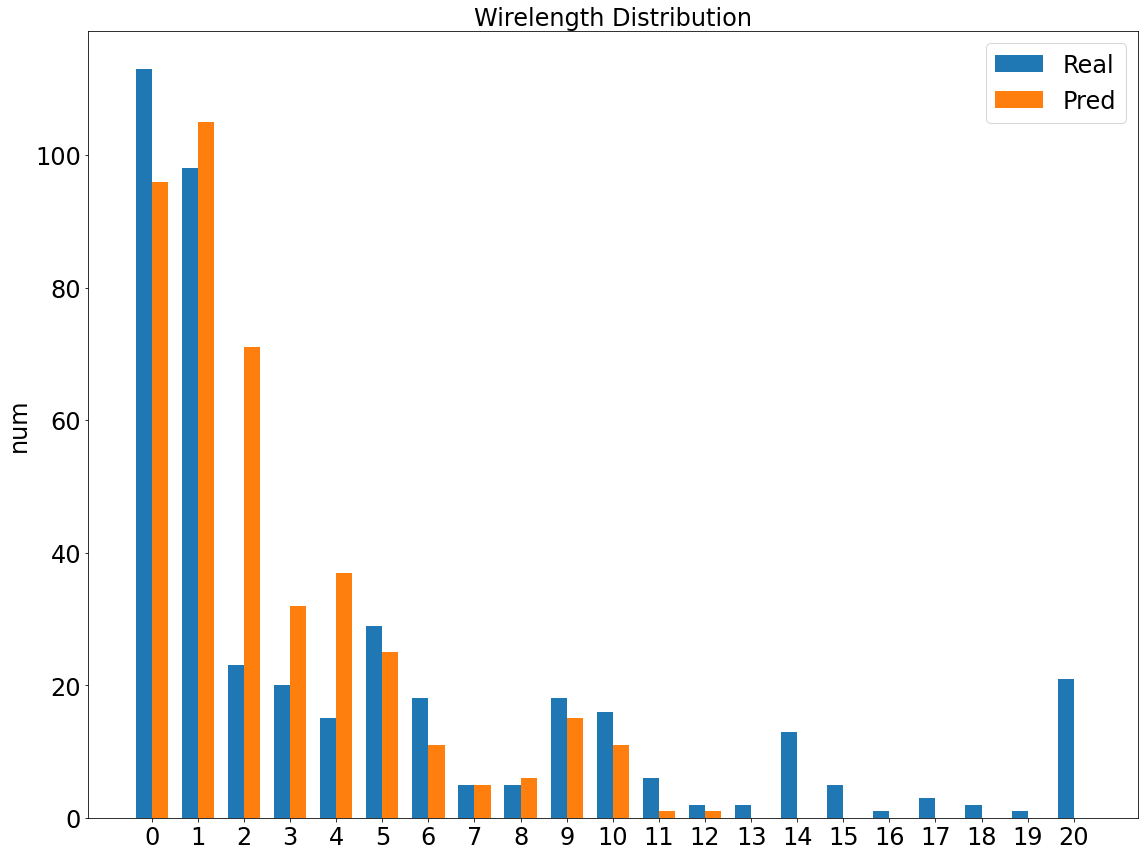

In [15]:
import matplotlib.pyplot as plt
labels = [i for i in range(N+1)]

x = np.arange(N+1)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, bin_num, width, label='Real')
rects2 = ax.bar(x + width/2, pred_bin_num, width, label='Pred')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('num', fontsize=24)
ax.set_title('Wirelength Distribution', fontsize=24)
plt.yticks(fontsize=24)
ax.set_xticks(x, labels, fontsize=24)
ax.legend(loc='best', fontsize=24)


fig.set_size_inches(16, 12)
fig.tight_layout()

plt.show()


In [ ]:
labels = [i for i in range(20)]



x = np.arange(20)  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mape_list, width, label='MAPE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('%', fontsize=24)
ax.set_title('MAPE', fontsize=24)
plt.yticks(fontsize=24)
ax.set_xticks(x, labels, fontsize=24)
ax.legend(loc='best', fontsize=24)


fig.set_size_inches(16, 12)
fig.tight_layout()

plt.show()